# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Pascal Tribel - [pascal.tribel@ulb.be](mailto:pascal.tribel@ulb.be)
### Cédric Simar - [cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)
### Gian Marco Paldino - [gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)

## TP 5 - Ensembles of models and feature selection

## Reminder:  Supervised learning

Supervised learning aims to model the (unknown) stochastic dependence between a set of $n$ inputs $x$ (also called features) and an output ${\mathbf y}$ on the basis of a training set $D_N$ of size $N$. Supervised learning tasks are decomposed into *regression* and *classification* tasks.
#### Regression
In regression the stochastic dependence is given by
$$ {\mathbf y} = f(x)+\mathbf{w}$$
where:
- $\mathbf{y} \in \mathbb{R}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)
- $\mathbf{w}$ denotes the noise, and is typically assumed that $E[\mathbf{w}]=0$ and the variance 
 $\text{Var}[\mathbf{w}]=\sigma^2_{\mathbf{w}}$ is constant
- $f(x)=E[{\mathbf y} | x]$ is the (unknown) mapping between input and outputs, also known as the *regression function*.

In regression, the goal of learning is to return an estimator 
$$h(x,\alpha)$$
of the regression function $f(x)$, where $\alpha$ denotes the set of parameters of the model $h$.

### Classification
In classification the target is a category and its conditional distribution is 
$$P({\mathbf y}|x)$$
where:
- $\mathbf{y} \in \{ C_1,\dots, C_K\}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)

In classification, the goal of learning is to return an estimator 
$$h(x,\alpha)$$
of the conditional probabiity $P({\mathbf y}|x)$, where $\alpha$ denotes the set of parameters of the model $h$. 

The learning of the estimator is done  on the basis of an available input/output
training set $D_N$ made of $N$ observation pairs $(\mathbf{x}_i,y_i)$ where $x_i \in \mathbb{R}^n$. 


## Feature selection

Feature selection and ensembles of models are two techniques which can be used to improve the accuracy of predictions.

Feature selection aims at reducing the dimensionality of the problem, and is useful when input variables contain redundant or irrelevant (noisy) information. Benefits are twofold: it decreases the training time by simplifying the problem, and it decreases the complexity of the predictive model. This in turn usually improves the prediction accuracy, since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant.
s
There are three main approaches to feature selection:
- **Filter methods:** 
These methods rely solely on the data and their intrinsic properties, without considering the impact of the selected features on the learning algorithm performance. For this reason, they are often used as preprocessing techniques.

- **Wrapper methods:** 
These methods assess subsets of variables according to their usefulness to a given predictor. The feature selection is performed using an evaluation function that includes the predictive performance of the considered learning algorithm as a selection criterion.

- **Embedded methods:** 
These methods are specific to given learning machines, and usually built-in in the learning procedure (e.g. random forest, regularization based techniques).

Ensembles of models consist in building several predictive models using resampled subsets of the original training set. The method works particularly well for predictive models with high variance (for example, decision trees or neural networks). The average prediction of the resulting models usually strongly decreases the variance component of the error, and as a consequence improves the prediction accuracy.

In this session, we will illustrate both techniques using the IMDB 5000 dataset, which contains 27 variables describing 5043 movies. The variables contain information about the director, actors, number of Facebook likes for each actor, duration, genre, language, country, etc... We will use them to predict the movie success (through the IMDB score). The dataset together with a description of the variables is at https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset.

The dataset is on the github of the course, in `movie_metadata.csv`

This is regression problem, with the IMDB score being the continuous target variable to predict.

#### Data overview and preprocessing

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv("movie_metadata.csv")
np.random.seed(2)
data = data.sample(1000) # Random subset of 1000 movies

print(data.shape)
data.head(2)

(1000, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4198,Color,Randall Miller,1.0,34.0,19.0,362.0,Elden Henson,882.0,333658.0,Comedy|Family|Musical|Romance|Short,...,2.0,English,USA,NaN,34000.0,1990.0,577.0,7.1,NaN,16
338,Color,Andrew Stanton,301.0,100.0,475.0,799.0,Stephen Root,1000.0,380838870.0,Adventure|Animation|Comedy|Family,...,866.0,English,USA,G,94000000.0,2003.0,939.0,8.2,1.85,11000


In [2]:
data.describe(include='all')

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,993,973,988.000000,996.000000,973.000000,994.000000,996,998.000000,8.320000e+02,1000,...,993.000000,998,998,930,9.040000e+02,971.000000,996.000000,1000.000000,938.000000,1000.000000
unique,2,771,NaN,NaN,NaN,NaN,852,NaN,NaN,360,...,NaN,19,30,14,NaN,NaN,NaN,NaN,NaN,NaN
top,Color,Woody Allen,NaN,NaN,NaN,NaN,Morgan Freeman,NaN,NaN,Drama,...,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,946,7,NaN,NaN,NaN,NaN,6,NaN,NaN,44,...,NaN,938,751,421,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,140.780364,106.428715,591.619733,606.791751,NaN,6378.470942,4.708677e+07,NaN,...,272.970796,NaN,NaN,NaN,3.555264e+07,2002.624099,1620.724900,6.420600,2.250458,7459.589000
std,NaN,NaN,122.036541,23.878039,2559.402129,1599.266382,NaN,10260.480083,7.016262e+07,NaN,...,387.030856,NaN,NaN,NaN,5.731897e+07,12.088241,3587.837829,1.100457,1.528877,18155.875279
min,NaN,NaN,1.000000,14.000000,0.000000,0.000000,NaN,0.000000,1.711000e+03,NaN,...,1.000000,NaN,NaN,NaN,3.250000e+03,1930.000000,0.000000,1.600000,1.200000,0.000000
25%,NaN,NaN,49.000000,94.000000,7.000000,147.250000,NaN,591.000000,4.436616e+06,NaN,...,69.000000,NaN,NaN,NaN,5.000000e+06,1999.000000,294.000000,5.800000,1.850000,0.000000
50%,NaN,NaN,107.000000,103.000000,50.000000,362.000000,NaN,989.000000,2.265441e+07,NaN,...,158.000000,NaN,NaN,NaN,2.000000e+07,2005.000000,602.000000,6.500000,2.350000,174.000000
75%,NaN,NaN,200.250000,116.250000,190.000000,628.500000,NaN,11000.000000,5.887055e+07,NaN,...,337.000000,NaN,NaN,NaN,4.400000e+07,2011.000000,939.000000,7.200000,2.350000,5000.000000


We see there is a mix of categorical and numerical variables, and some missing values. In order to simplify the analysis, let us remove the categorical variables, and replace the NA values with the mean values of the variables.

In [3]:
# Identify factor (categorical) variables
factor_cols = data.select_dtypes(include=['object']).columns
factor_cols

Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'movie_title', 'actor_3_name', 'plot_keywords', 'movie_imdb_link',
       'language', 'country', 'content_rating'],
      dtype='object')

In [4]:
# Remove categorical variables
data_preprocessed = data.drop(columns=factor_cols)

# Replace NaN with mean
data_preprocessed = data_preprocessed.apply(lambda x: x.fillna(x.mean()))

data_preprocessed.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,140.780364,106.428715,591.619733,606.791751,6378.470942,4.708677e+07,8.008905e+04,9470.591000,1.352705,272.970796,3.555264e+07,2002.624099,1620.724900,6.420600,2.250458,7459.589000
std,121.301374,23.830187,2524.578708,1594.456547,10250.204186,6.399168e+07,1.300510e+05,13847.572387,2.087632,385.672508,5.449535e+07,11.911494,3580.647766,1.100457,1.480674,18155.875279
min,1.000000,14.000000,0.000000,0.000000,0.000000,1.711000e+03,6.000000e+00,0.000000,0.000000,1.000000,3.250000e+03,1930.000000,0.000000,1.600000,1.200000,0.000000
25%,50.000000,94.000000,7.000000,148.000000,591.000000,6.977259e+06,8.901500e+03,1429.750000,0.000000,69.750000,7.000000e+06,1999.000000,294.750000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,53.500000,366.500000,989.000000,3.415931e+07,3.565200e+04,3009.500000,1.000000,159.000000,2.300000e+07,2005.000000,605.000000,6.500000,2.250458,174.000000
75%,199.250000,116.000000,223.000000,626.250000,11000.000000,4.792683e+07,9.295550e+04,13720.500000,2.000000,335.250000,4.000000e+07,2010.000000,940.000000,7.200000,2.350000,5000.000000
max,813.000000,226.000000,22000.000000,23000.000000,137000.000000,4.745447e+08,1.347461e+06,137712.000000,31.000000,5060.000000,1.000000e+09,2016.000000,23000.000000,9.100000,16.000000,164000.000000


### Input and output variables

The output variable (Y) is the `imdb_score`, and all other variables (X) are considered as inputs.

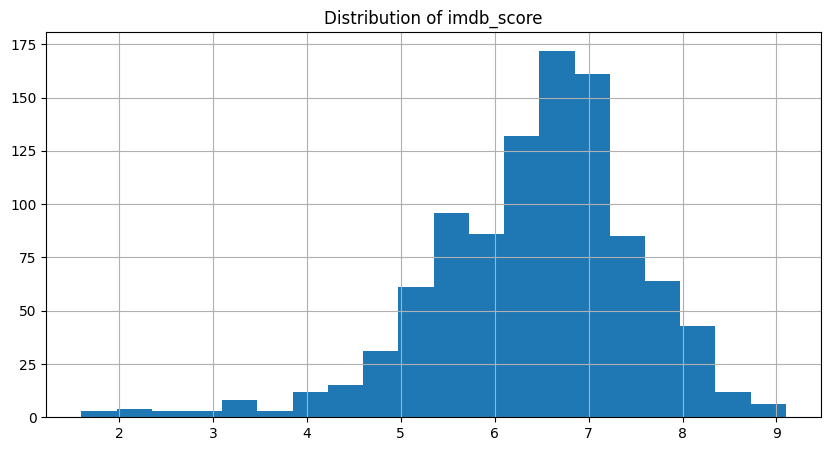

Mean of Y: 6.4206
Variance of Y: 1.2097956399999998


In [69]:
Y = data_preprocessed['imdb_score'].values
X = data_preprocessed.drop(columns=['imdb_score'])

N = X.shape[0] ## number of observations
n = X.shape[1] ## number of input features

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(Y, bins=20)
plt.title("Distribution of imdb_score")
plt.grid()
plt.show()

print("Mean of Y:", np.mean(Y))
print("Variance of Y:", np.var(Y))

### 1) Modelling with linear and decision tree models

#### Linear model

* Create a linear model $h(x)$ for predicting the IMDB score on the basis of the input variables, and compute its empirical (or training) mean square error.

In [53]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, Y)
Y_hat = model.predict(X)

empirical_error = np.mean((Y_hat - Y)**2)
print("Empirical error=", round(empirical_error,4))

Empirical error= 0.9154


* Which input variables are statistically correlated with the output?

In Python, we can check the coefficients of the linear model.

In [54]:
coefs = pd.Series(model.coef_, index=X.columns)
coefs

num_critic_for_reviews       1.700807e-03
duration                     5.405962e-03
director_facebook_likes      8.798490e-06
actor_3_facebook_likes      -1.124559e-05
actor_1_facebook_likes       1.339764e-05
gross                       -1.345351e-09
num_voted_users              3.948450e-06
cast_total_facebook_likes   -1.178803e-05
facenumber_in_poster        -1.145375e-02
num_user_for_reviews        -6.795024e-04
budget                      -1.265215e-09
title_year                  -2.180756e-02
actor_2_facebook_likes       1.923221e-05
aspect_ratio                 8.809596e-02
movie_facebook_likes         2.258206e-06
dtype: float64

* Compute the validation error with a 10-fold cross-validation

In [55]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=3)
CV_err_lm_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = LinearRegression()
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_lm_single_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=", round(np.mean(CV_err_lm_single_model),4), 
      "; std dev=", round(np.std(CV_err_lm_single_model),4))

CV error= 0.9817 ; std dev= 0.2359


#### Decision tree

* Modify the previous code to compute the empirical error using a decision tree model. Use sklearn's `DecisionTreeRegressor`.

In [56]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=3)
model.fit(X, Y)
Y_hat = model.predict(X)

empirical_error = np.mean((Y_hat - Y)**2)
print("Empirical error=", round(empirical_error,4))

Empirical error= 0.0


* Plot the resulting tree is more complicated in Python due to size, but we can just visualize its structure or get the depth.

In [57]:
model.get_depth(), model.get_n_leaves()

(29, 867)

* What is the 10-fold cross-validation error using a decision tree model?

In [58]:
CV_err_rpart_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = DecisionTreeRegressor(random_state=3)
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_rpart_single_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=", round(np.mean(CV_err_rpart_single_model),4), 
      "; std dev=", round(np.std(CV_err_rpart_single_model),4))

CV error= 1.4988 ; std dev= 0.2935


Why is the result so different using the 10-fold cross-validation?

#### Ridge regression with LOO-CV
Recall: Ridge regression looks like a linear regression but includes a penalty term for large coefficients:
$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \alpha \| \beta \|^2.
$$


Ridge also has a known closed-form:
$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \alpha I)^{-1} X^\top Y.
$$

* Leave-one out cross-validation is a method that consists in evaluating a given model by training it on the entire training set, except for one sample used for validation. By performing this validation, eliminating each of the samples at a time, we get an estimation of the quality of the model.
* Then, the coefficients can give an idea of the importance of each of the features in the prediction task.

## 2) Ensemble of models

Let us now create an ensemble of R=20 linear models to make predictions.

In [12]:
R = 20
CV_err_lm_ensemble_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    Y_hat_ts_ensemble = np.zeros((X_ts.shape[0], R))
    for r in range(R):
        # Resample the training indices
        idx_tr_resample = np.random.choice(train_index, size=len(train_index), replace=True)
        X_tr_res = X.iloc[idx_tr_resample]
        Y_tr_res = Y[idx_tr_resample]
        
        model = LinearRegression()
        model.fit(X_tr_res, Y_tr_res)
        Y_hat_ts_ensemble[:, r] = model.predict(X_ts)
    
    Y_hat_ts = np.mean(Y_hat_ts_ensemble, axis=1)
    CV_err_lm_ensemble_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=", round(np.mean(CV_err_lm_ensemble_model),4), 
      "; std dev=", round(np.std(CV_err_lm_ensemble_model),4))

# Is the CV error lower?
print("Is ensemble error lower than single model?", 
      np.mean(CV_err_lm_ensemble_model) < np.mean(CV_err_lm_single_model))

CV error= 0.9775 ; std dev= 0.2393
Is ensemble error lower than single model? True


* Use a decision tree as the base model. Is the CV error lower?

In [13]:
R = 20
CV_err_rpart_ensemble_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    Y_hat_ts_ensemble = np.zeros((X_ts.shape[0], R))
    for r in range(R):
        idx_tr_resample = np.random.choice(train_index, size=len(train_index), replace=True)
        X_tr_res = X.iloc[idx_tr_resample]
        Y_tr_res = Y[idx_tr_resample]
        
        model = DecisionTreeRegressor(random_state=r)
        model.fit(X_tr_res, Y_tr_res)
        Y_hat_ts_ensemble[:, r] = model.predict(X_ts)
    
    Y_hat_ts = np.mean(Y_hat_ts_ensemble, axis=1)
    CV_err_rpart_ensemble_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=", round(np.mean(CV_err_rpart_ensemble_model),4), 
      "; std dev=", round(np.std(CV_err_rpart_ensemble_model),4))

# Is ensemble error lower?
print("Is ensemble error lower than single tree model?", 
      np.mean(CV_err_rpart_ensemble_model) < np.mean(CV_err_rpart_single_model))

CV error= 0.8092 ; std dev= 0.1835
Is ensemble error lower than single tree model? True


## 3) Feature selection

### Filter methods

#### Correlation with the output

The following code performs feature selection by keeping the most correlated variables with the output. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?

In [14]:
correlations = np.abs(X.corrwith(pd.Series(Y)))
ranking_corr_idx = correlations.sort_values(ascending=False).index

CV_err = np.zeros((n,10))

fold_id = 0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    for nb_features in range(1, n+1):
        selected_features = ranking_corr_idx[:nb_features]
        model = LinearRegression()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err[nb_features-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))

print("Correlation ranking:")
print(ranking_corr_idx.tolist())

#Features: 1 ; CV error= 1.1482 ; std dev= 0.2285
#Features: 2 ; CV error= 1.144 ; std dev= 0.2237
#Features: 3 ; CV error= 1.1452 ; std dev= 0.2227
#Features: 4 ; CV error= 1.1586 ; std dev= 0.2355
#Features: 5 ; CV error= 1.1435 ; std dev= 0.2556
#Features: 6 ; CV error= 1.1454 ; std dev= 0.2555
#Features: 7 ; CV error= 1.1143 ; std dev= 0.2732
#Features: 8 ; CV error= 1.1209 ; std dev= 0.2913
#Features: 9 ; CV error= 1.115 ; std dev= 0.2858
#Features: 10 ; CV error= 1.0372 ; std dev= 0.254
#Features: 11 ; CV error= 0.9768 ; std dev= 0.2331
#Features: 12 ; CV error= 0.9761 ; std dev= 0.2313
#Features: 13 ; CV error= 0.978 ; std dev= 0.2319
#Features: 14 ; CV error= 0.9794 ; std dev= 0.234
#Features: 15 ; CV error= 0.9817 ; std dev= 0.2359
Correlation ranking:
['num_user_for_reviews', 'cast_total_facebook_likes', 'actor_1_facebook_likes', 'budget', 'duration', 'actor_3_facebook_likes', 'movie_facebook_likes', 'num_critic_for_reviews', 'aspect_ratio', 'title_year', 'num_voted_users', '

#### mRMR

We will implement a simple mRMR feature selection. mRMR uses mutual information. We will approximate mutual information via the correlation-based formula provided.

In [15]:
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0,1]
    # Avoid invalid value if correlation == 1 or == -1
    if abs(c)==1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi = mutual_info_corr(X_tr[col].values, Y_tr)
        mis.append(mi)
    return np.array(mis)

CV_err = np.zeros((n,10))

fold_id = 0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            # Compute pairwise mi between selected and candidates
            mi_sc = []
            for cidx in candidates:
                col_c = X_tr.iloc[:, cidx]
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx]
                    # Compute mutual info between col_s and col_c
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
    
    # selected is the ranking
    for nb_features in range(1, n+1):
        features_to_use = [X.columns[i] for i in selected[:nb_features]]
        model = LinearRegression()
        model.fit(X_tr[features_to_use], Y_tr)
        Y_hat_ts = model.predict(X_ts[features_to_use])
        CV_err[nb_features-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))
    
print("Selected features ranking (mRMR):")
print([X.columns[i] for i in selected])

#Features: 1 ; CV error= 1.0427 ; std dev= 0.2024
#Features: 2 ; CV error= 1.0018 ; std dev= 0.1985
#Features: 3 ; CV error= 1.0031 ; std dev= 0.196
#Features: 4 ; CV error= 0.9925 ; std dev= 0.2068
#Features: 5 ; CV error= 0.9898 ; std dev= 0.208
#Features: 6 ; CV error= 0.9896 ; std dev= 0.2094
#Features: 7 ; CV error= 0.9938 ; std dev= 0.2164
#Features: 8 ; CV error= 0.9807 ; std dev= 0.2155
#Features: 9 ; CV error= 0.9647 ; std dev= 0.2146
#Features: 10 ; CV error= 0.9663 ; std dev= 0.22
#Features: 11 ; CV error= 0.9697 ; std dev= 0.2262
#Features: 12 ; CV error= 0.9693 ; std dev= 0.2266
#Features: 13 ; CV error= 0.9602 ; std dev= 0.2241
#Features: 14 ; CV error= 0.9785 ; std dev= 0.2341
#Features: 15 ; CV error= 0.9817 ; std dev= 0.2359
Selected features ranking (mRMR):
['num_voted_users', 'title_year', 'aspect_ratio', 'duration', 'facenumber_in_poster', 'director_facebook_likes', 'actor_1_facebook_likes', 'movie_facebook_likes', 'budget', 'actor_3_facebook_likes', 'gross', 'actor

#### PCA

The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model.

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

CV_err = np.zeros((n,10))
fold_id = 0
for train_index, test_index in kf.split(X_pca):
    X_tr, X_ts = X_pca[train_index], X_pca[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    for nb_components in range(1, n+1):
        model = LinearRegression()
        model.fit(X_tr[:, :nb_components], Y_tr)
        Y_hat_ts = model.predict(X_ts[:, :nb_components])
        CV_err[nb_components-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))

#Features: 1 ; CV error= 1.1915 ; std dev= 0.213
#Features: 2 ; CV error= 1.1902 ; std dev= 0.2177
#Features: 3 ; CV error= 1.0599 ; std dev= 0.2286
#Features: 4 ; CV error= 1.0629 ; std dev= 0.2351
#Features: 5 ; CV error= 1.0615 ; std dev= 0.2417
#Features: 6 ; CV error= 1.0629 ; std dev= 0.2413
#Features: 7 ; CV error= 1.0639 ; std dev= 0.2431
#Features: 8 ; CV error= 1.0622 ; std dev= 0.2463
#Features: 9 ; CV error= 1.065 ; std dev= 0.2461
#Features: 10 ; CV error= 1.0578 ; std dev= 0.2346
#Features: 11 ; CV error= 1.0679 ; std dev= 0.2483
#Features: 12 ; CV error= 1.0569 ; std dev= 0.2781
#Features: 13 ; CV error= 0.9919 ; std dev= 0.2374
#Features: 14 ; CV error= 0.9926 ; std dev= 0.2396
#Features: 15 ; CV error= 0.9817 ; std dev= 0.2359


### Wrapper method: Forward selection

In [17]:
# Forward selection
selected = []
for round_i in range(n):
    candidates = list(set(range(n)) - set(selected))
    CV_err_temp = []
    for c in candidates:
        features_to_include = selected + [c]
        fold_errors = []
        for train_index, test_index in kf.split(X):
            X_tr, X_ts = X.iloc[train_index, features_to_include], X.iloc[test_index, features_to_include]
            Y_tr, Y_ts = Y[train_index], Y[test_index]
            
            model = LinearRegression()
            model.fit(X_tr, Y_tr)
            Y_hat_ts = model.predict(X_ts)
            fold_errors.append(np.mean((Y_hat_ts - Y_ts)**2))
        CV_err_temp.append(np.mean(fold_errors))
    
    best_candidate = candidates[np.argmin(CV_err_temp)]
    selected.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV error=", round(min(CV_err_temp),4), 
          "; std dev=", round(np.std(fold_errors),4))

print("Selected features:", [X.columns[i] for i in selected])

Round 1 ; Selected feature: 6 ; CV error= 1.0427 ; std dev= 0.2234
Round 2 ; Selected feature: 11 ; CV error= 1.0018 ; std dev= 0.209
Round 3 ; Selected feature: 0 ; CV error= 0.9876 ; std dev= 0.2093
Round 4 ; Selected feature: 9 ; CV error= 0.9683 ; std dev= 0.2101
Round 5 ; Selected feature: 13 ; CV error= 0.9592 ; std dev= 0.1934
Round 6 ; Selected feature: 1 ; CV error= 0.9502 ; std dev= 0.1908
Round 7 ; Selected feature: 5 ; CV error= 0.9466 ; std dev= 0.1992
Round 8 ; Selected feature: 4 ; CV error= 0.9471 ; std dev= 0.2068
Round 9 ; Selected feature: 14 ; CV error= 0.9482 ; std dev= 0.2066
Round 10 ; Selected feature: 12 ; CV error= 0.9493 ; std dev= 0.207
Round 11 ; Selected feature: 3 ; CV error= 0.9497 ; std dev= 0.2297
Round 12 ; Selected feature: 8 ; CV error= 0.951 ; std dev= 0.2129
Round 13 ; Selected feature: 2 ; CV error= 0.9531 ; std dev= 0.2154
Round 14 ; Selected feature: 7 ; CV error= 0.9561 ; std dev= 0.2166
Round 15 ; Selected feature: 10 ; CV error= 0.9817 ; std

## Further preprocessing to add categorical variables

Categorical variables usually need to be transformed with 'one-hot-encoding' in order to be processed by a learning algorithm.

In the following, we add some categorical variables (color, language, country, content_rating) to the preprocessed dataset, and use them to improve prediction performance.

We can do the one-hot encoding using pandas `get_dummies`.

In [18]:
factor_vars = factor_cols
data_factor = data[factor_vars]

variables_to_keep = ["color", "language", "country", "content_rating"]

data_factor_onehot = pd.get_dummies(data_factor[variables_to_keep], prefix=variables_to_keep, dummy_na=False)

data_preprocessed_extended = pd.concat([data_preprocessed, data_factor_onehot], axis=1)
X = data_preprocessed_extended.drop(columns=['imdb_score'])
Y = data_preprocessed_extended['imdb_score'].values
N, n = X.shape

X.columns = [c.replace(" ", "_").replace("-", "_") for c in X.columns]

## Using other predictive models

We can try other models like SVM (SVR), Neural Networks (MLPRegressor), K-Nearest Neighbors (KNeighborsRegressor) and see if performance improves.

In [19]:
from sklearn.svm import SVR

CV_err_svm_single_model = []
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = SVR()
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_svm_single_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=",round(np.mean(CV_err_svm_single_model),4),
      "; std dev=", round(np.std(CV_err_svm_single_model),4))

CV error= 1.1883 ; std dev= 0.213


In [20]:
# Feature selection with mRMR for SVM

n_variables = 10

CV_err_svm_single_model_fs = np.zeros((n_variables,10))
fold_id = 0

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    # Evaluate performance with subsets of selected features
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        model = SVR()
        model.fit(X_tr[feats], Y_tr)
        Y_hat_ts = model.predict(X_ts[feats])
        CV_err_svm_single_model_fs[nb_features-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_svm_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_svm_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 1.21 ; std dev= 0.2373
#Features: 2 ; CV error= 1.1264 ; std dev= 0.2295
#Features: 3 ; CV error= 1.0468 ; std dev= 0.2358
#Features: 4 ; CV error= 1.0875 ; std dev= 0.2352
#Features: 5 ; CV error= 1.1004 ; std dev= 0.2347
#Features: 6 ; CV error= 1.1629 ; std dev= 0.2201
#Features: 7 ; CV error= 1.1787 ; std dev= 0.2237
#Features: 8 ; CV error= 1.1783 ; std dev= 0.2237
#Features: 9 ; CV error= 1.1782 ; std dev= 0.2238
#Features: 10 ; CV error= 1.1781 ; std dev= 0.2239


In [37]:
from sklearn.neural_network import MLPRegressor

CV_err_nnet_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]

    # Rescale input to 0-1
    min_X, max_X = np.min(X_tr), np.max(X_tr)
    X_tr = (X_tr-min_X)/(max_X-min_X)
    X_ts = (X_ts-min_X)/(max_X-min_X)
    
    # Rescale output to 0-1
    Y_tr_rescale = Y_tr/10.0
    model = MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=1000000, random_state=3)
    model.fit(X_tr, Y_tr_rescale)
    Y_hat_ts = model.predict(X_ts)*10.0
    CV_err_nnet_single_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=",round(np.mean(CV_err_nnet_single_model),4), "; std dev=", round(np.std(CV_err_nnet_single_model),4))

CV error= 1.1967 ; std dev= 0.2135


In [39]:
CV_err_nnet_single_model_fs = np.zeros((n_variables,10))
fold_id=0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    # Rescale input to 0-1
    min_X, max_X = np.min(X_tr), np.max(X_tr)
    X_tr = (X_tr-min_X)/(max_X-min_X)
    X_ts = (X_ts-min_X)/(max_X-min_X)
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        Y_tr_rescale = Y_tr/10.0
        model = MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=1000000, random_state=3)
        model.fit(X_tr[feats], Y_tr_rescale)
        Y_hat_ts = model.predict(X_ts[feats])*10.0
        CV_err_nnet_single_model_fs[nb_features-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_nnet_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_nnet_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 1.2132 ; std dev= 0.2146
#Features: 2 ; CV error= 1.2131 ; std dev= 0.2127
#Features: 3 ; CV error= 1.2132 ; std dev= 0.2117
#Features: 4 ; CV error= 1.2132 ; std dev= 0.2132
#Features: 5 ; CV error= 1.213 ; std dev= 0.2127
#Features: 6 ; CV error= 1.2135 ; std dev= 0.2129
#Features: 7 ; CV error= 1.3368 ; std dev= 0.248
#Features: 8 ; CV error= 1.1862 ; std dev= 0.2101
#Features: 9 ; CV error= 1.1856 ; std dev= 0.2141
#Features: 10 ; CV error= 1.2076 ; std dev= 0.2133


In [40]:
from sklearn.neighbors import KNeighborsRegressor

CV_err_lazy_single_model = []
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_lazy_single_model.append(np.mean((Y_hat_ts - Y_ts)**2))

print("CV error=",round(np.mean(CV_err_lazy_single_model),4),
      "; std dev=", round(np.std(CV_err_lazy_single_model),4))

CV error= 1.3163 ; std dev= 0.2438


In [41]:
# Feature selection for KNN using mRMR
CV_err_lazy_single_model_fs = np.zeros((n_variables,10))
fold_id=0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        model = KNeighborsRegressor(n_neighbors=5)
        model.fit(X_tr[feats], Y_tr)
        Y_hat_ts = model.predict(X_ts[feats])
        CV_err_lazy_single_model_fs[nb_features-1, fold_id] = np.mean((Y_hat_ts - Y_ts)**2)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_lazy_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_lazy_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 1.2271 ; std dev= 0.2408
#Features: 2 ; CV error= 1.2897 ; std dev= 0.2448
#Features: 3 ; CV error= 1.1045 ; std dev= 0.2074
#Features: 4 ; CV error= 1.1318 ; std dev= 0.2232
#Features: 5 ; CV error= 1.1636 ; std dev= 0.2545
#Features: 6 ; CV error= 1.2591 ; std dev= 0.293
#Features: 7 ; CV error= 1.3438 ; std dev= 0.2411
#Features: 8 ; CV error= 1.2756 ; std dev= 0.1949
#Features: 9 ; CV error= 1.277 ; std dev= 0.1748
#Features: 10 ; CV error= 1.2951 ; std dev= 0.1621


#### Ridge regression with LOO-CV
Recall: Ridge regression looks like a linear regression but includes a penalty term for large coefficients:
$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \alpha \| \beta \|^2.
$$


Ridge also has a known closed-form:
$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \alpha I)^{-1} X^\top Y.
$$

* Leave-one out cross-validation is a method that consists in evaluating a given model by training it on the entire training set, except for one sample used for validation. By performing this validation, eliminating each of the samples at a time, we get an estimation of the quality of the model.
* Then, the coefficients can give an idea of the importance of each of the features in the prediction task.

In [79]:
Y = data_preprocessed['imdb_score'].values
X = data_preprocessed.drop(columns=['imdb_score'])
X_np = X.to_numpy()

best alpha: 1
Greatests coefficients indexes: [ 0 14  9  2]
Greatests coefficients: [ 1.3710444   0.07399823 -0.02049075  0.00767804]


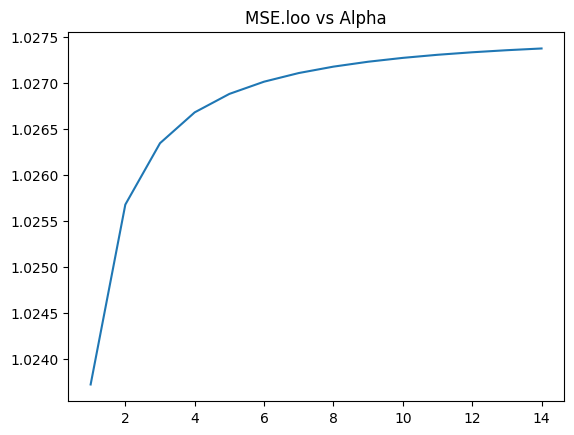

In [80]:
N = X_np.shape[0]
alphas = np.arange(1, X_np.shape[1], 1) 
E = np.empty((N, len(alphas)))  
E[:] = np.nan

for i in range(N):
    Xtr = np.column_stack((np.ones(N - 1), np.delete(X_np, i, axis=0)))
    Ytr = np.delete(Y, i)
    
    Xts = np.concatenate(([1], X_np[i,]))
    
    cnt = 0
    for alpha in alphas:
        A = Xtr.T @ Xtr + alpha * np.eye(n + 1)
        b = Xtr.T @ Ytr
        betahat = np.linalg.inv(A) @ b
        Yhati = Xts @ betahat
        E[i, cnt] = (Y[i] - Yhati) ** 2
        cnt += 1

mseloo = np.mean(E, axis=0)

bestAlpha = alphas[np.argmin(np.mean(E, axis=0))]
print(f"best alpha: {bestAlpha}")

XX = np.column_stack((np.ones(N), X_np))
A_final = np.dot(XX.T, XX) + bestAlpha * np.eye(n + 1)
b_final = np.dot(XX.T, Y)
betahat = np.linalg.inv(A_final) @ XX.T @ Y

abs_betahat = np.abs(betahat)
sorted_indices = np.argsort(-abs_betahat)
top4 = sorted_indices[:4] 
print(f"Greatests coefficients indexes: {top4}")
print(f"Greatests coefficients: {betahat[top4]}")
plt.plot(alphas, mseloo)
plt.title('MSE.loo vs Alpha')
plt.show()